<a href="https://colab.research.google.com/github/lpoggetto/fiap_liveness/blob/main/trabalho_computer_vision.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [33]:
!mkdir imagens
!rm -rf sample_data/*

mkdir: cannot create directory ‘imagens’: File exists


In [33]:
 !pip install git+https://github.com/hukkelas/DSFD-Pytorch-Inference.git
 !pip install face_detection

### Importando os pacotes utilizados

In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
try:
  import face_detection
except:
  !pip install face_detection
  import face_detection

try:
  import mediapipe as mp
except:
  !pip install mediapipe
  import mediapipe as mp
import warnings
warnings.filterwarnings('ignore')

#Exibição na mesma tela do Jupyter
%matplotlib inline
sns.set_style("whitegrid", {'axes.grid' : False})

# pacotes utilizados para tirar foto
from IPython.display import display, Javascript, Image
from google.colab.output import eval_js
from base64 import b64decode

In [54]:
# funcao para tirar foto
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename

try:
  filename = take_photo("imagens/foto.jpg")
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

<IPython.core.display.Javascript object>

Saved to imagens/foto.jpg
'module' object is not callable


In [ ]:
from IPython.display import HTML, display

# JavaScript code to capture video
html_code = """
<video id="video" width="640" height="480" autoplay></video>
<button id="startButton">Start Recording</button>
<button id="stopButton" disabled>Stop Recording</button>
<video id="playback" width="640" height="480" controls></video>
<a id="downloadLink" download="recorded-video.webm"></a>

<script>
    const video = document.querySelector('#video');
    const playback = document.querySelector('#playback');
    const downloadLink = document.querySelector('#downloadLink');
    const startButton = document.querySelector('#startButton');
    const stopButton = document.querySelector('#stopButton');

    navigator.mediaDevices.getUserMedia({ video: true }).then((stream) => {
        video.srcObject = stream;
        let mediaRecorder;
        const chunks = [];

        startButton.onclick = () => {
            mediaRecorder = new MediaRecorder(stream);
            mediaRecorder.start();
            startButton.disabled = true;
            stopButton.disabled = false;

            mediaRecorder.ondataavailable = (event) => chunks.push(event.data);
            mediaRecorder.onstop = () => {
                const blob = new Blob(chunks, { type: 'video/webm' });
                playback.src = URL.createObjectURL(blob);
                downloadLink.href = playback.src;
                downloadLink.textContent = 'Download Video';
                startButton.disabled = false;
                stopButton.disabled = true;
            };
        };

        stopButton.onclick = () => mediaRecorder.stop();
    });
</script>
"""

# Display the HTML interface
display(HTML(html_code))


### Montando detector de faces

Utilizando o algoritmo DSFDDetector para detectar uma face

In [56]:
print(face_detection.available_detectors)

['DSFDDetector', 'RetinaNetResNet50', 'RetinaNetMobileNetV1']


In [60]:
def detector_faces(path_foto):
  # Criando o detector de faces
  detector = face_detection.build_detector(
        "DSFDDetector",
        confidence_threshold=.5,
        nms_iou_threshold=.3
        )

  # Convertendo BGR -> RGB
  im = cv2.imread(path_foto)[:, :, ::-1]

  # array com as faces detectadas
  detections = detector.detect(im)

  # iterando para desenhar retangulo na face
  for det in detections:
      x1, y1, x2, y2, score = det  # Unpack the bounding box and confidence
      x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])  # Convert to integers

      # Ensure im is a NumPy array with dtype uint8
      im = im.astype(np.uint8)

      # Draw a rectangle for the bounding box
      cv2.rectangle(im, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue rectangle

# Plot the image with bounding boxes and lines
  plt.figure(figsize=(10, 8))
  plt.imshow(im)
  plt.axis("off")
  plt.show()

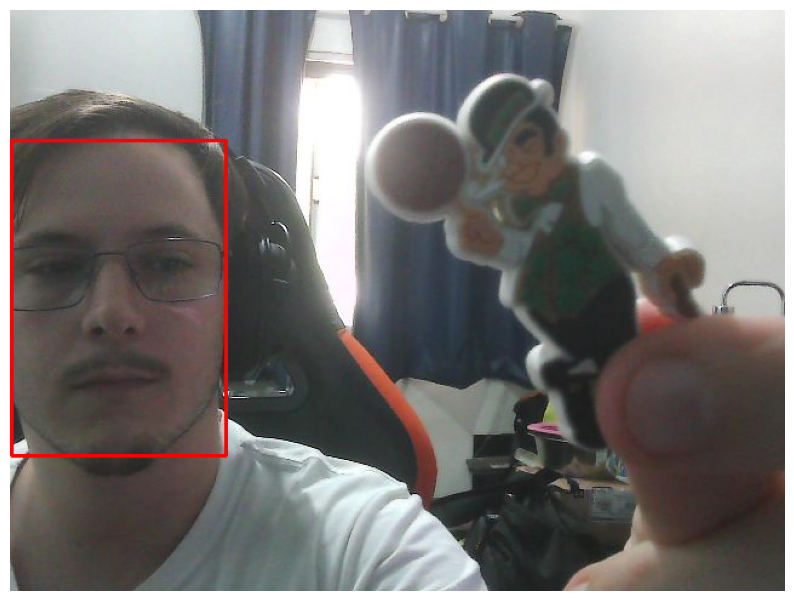

In [61]:
detector_faces("/content/imagens/foto.jpg")

In [65]:
def detector_faces_video(video_path, output_path):
    # Create the face detector
    detector = face_detection.build_detector(
        "DSFDDetector",
        confidence_threshold=0.5,
        nms_iou_threshold=0.3
    )

    # Open the video file
    video = cv2.VideoCapture(video_path)

    # Get video properties
    fps = int(video.get(cv2.CAP_PROP_FPS))
    width = int(video.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(video.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'VP80')  # WebM codec
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    while True:
        ret, frame = video.read()
        if not ret:
            break

        # Convert frame to RGB
        rgb_frame = frame[:, :, ::-1]

        # Detect faces
        detections = detector.detect(rgb_frame)

        # Draw rectangles for detected faces
        for det in detections:
            x1, y1, x2, y2, score = det
            x1, y1, x2, y2 = map(int, [x1, y1, x2, y2])
            cv2.rectangle(frame, (x1, y1), (x2, y2), (255, 0, 0), 2)  # Blue rectangle

        # Write the processed frame to the output video
        out.write(frame)

    # Release resources
    video.release()
    out.release()
    print(f"Processed video saved to: {output_path}")

# Example usage
input_video_path = '/path/to/input/video.webm'
output_video_path = '/path/to/output/video.webm'

detector_faces_video('/content/imagens/recorded-video(1).webm', '/content/imagens/recorded-video(1)_processado.webm')


Processed video saved to: /content/imagens/recorded-video(1)_processado.webm
